In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
from sklearn.metrics import r2_score
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [4]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [5]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [6]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [7]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [8]:
glm = 1
dir_glm = ssingle.get_dir_glmsingle(glm)

In [9]:
list_nn = su.get_list_sn()

In [10]:
alpha = 0.05
thresh = scipy.stats.t.ppf(1-0.5*alpha, df=len(list_nn)-1)
print(thresh)

2.200985160082949


---

In [11]:
dir_work = join(dir_glm,'surfaceWB')
dir_work

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/glm_1/surfaceWB'

In [12]:
list_roi = simage.get_list_roi()

In [13]:
border = simage.get_border(join(dir_git,'surfAnalysisPy'))
hem = 'L'

---

In [14]:
subj = 'S01'

In [15]:
reginfo = deal_spm.load_reginfo(subj,dir_glm)
reginfo

,sn,run,name,ons
0,1,1,"(2,S)",6.03
1,1,1,"(4,S)",11.03
2,1,1,"(4,L)",16.03
3,1,1,"(2,L)",21.03
4,1,1,"(1,S)",26.03
...,...,...,...,...
539,1,8,"(3,S)",3215.03
540,1,8,"(3,L)",3220.03
541,1,8,"(2,S)",3225.03
542,1,8,"(2,L)",3230.03


In [23]:
idx_letter = np.array([True if 'L' in name else False for name in reginfo.name])
idx_spatial = np.array([True if 'S' in name else False for name in reginfo.name])
print(idx_letter.shape, idx_spatial.shape)

(544,) (544,)


### Load $\beta$s

In [55]:
dataset = {}
for ii, nn in enumerate(tqdm(list_nn)):
    subj = 'S'+nn
    fname = join(dir_work,subj,'%s.%s.glm_%d.beta.func.gii'%(subj,hem,glm,))
    betas = nb.load(fname).darrays
    for kk, darray in enumerate(betas):
        roi = str(list_roi[kk])
        beta = darray.data
        if ii==0:
            dataset[roi] = np.ones([len(list_nn),len(betas),len(beta)]) * np.nan
        dataset[roi][ii,kk,:] = beta.data

100%|███████████████████████████████████████████████████| 12/12 [07:21<00:00, 36.77s/it]


In [19]:
vmin, vmax = -8, 8

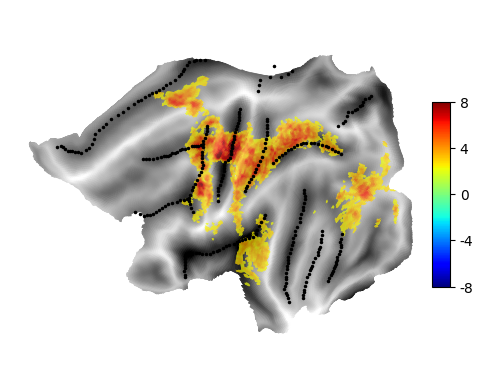

In [21]:
g = surf.plot.plotmap(
    data=np.mean(dataset, axis=0),
    surf='fs32k_%s'%hem,
    alpha=0.7,
    cmap=cm.jet, colorbar=True, cscale=[vmin,vmax],
    threshold=thresh,
    borders=border, bordercolor='black', bordersize=3,
    overlay_type='func', render='matplotlib'
)

### Spatial

In [22]:
dataset = []
for nn in tqdm(list_nn):
    subj = 'S'+nn
    fname = join(dir_work,subj,'%s.%s.glm_%d.t.func.gii'%(subj,hem,glm))
    data = []
    tmp = nb.load(fname).darrays
    for darray in tmp:
        data.append(darray.data)
    data = np.array(data)
    dataset.append(np.mean(data[idx_spatial,:], axis=0))
dataset = np.array(dataset)
dataset.shape

100%|███████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.46it/s]


(12, 32492)

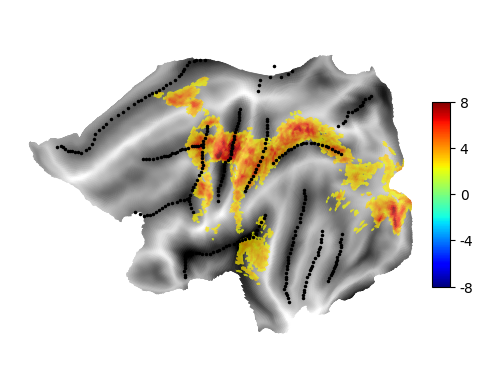

In [23]:
g = surf.plot.plotmap(
    data=np.mean(dataset, axis=0),
    surf='fs32k_%s'%hem,
    alpha=0.7,
    cmap=cm.jet, colorbar=True, cscale=[vmin,vmax],
    threshold=thresh,
    borders=border, bordercolor='black', bordersize=3,
    overlay_type='func', render='matplotlib'
)

---